<a href="https://colab.research.google.com/github/paaaaat/mining-massive-datasets-project/blob/main/Q_VIPER_Patrick_Hamzaj_VR474246.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Q-VIPER: Quantitative Vertical Bitwise Algorithm to Mine Frequent Patterns**
<hr />

Frequent pattern mining aims to discover frequently occurring sets of items from big data. Given a series of transactions containing a set of items, frequent pattern mining seeks to determine the sets of items, which occur in many transactions. Frequent patterns can be discovered horizontally by transaction-centric mining algorithms or vertically by item-centric mining algorithms. Regardless of their mining direction, traditional frequent pattern mining algorithms aim to discover boolean patterns in the sense that patterns capture the presence (or absence) of items within the discovered patterns (e.g. A-Priori algorithm). However, there are many real-life situations in which quantities of items within the patterns are important. For example, the quantity of items may affect profits of selling the items, Hence, Q-VIPER is a quantitative vertical bitwise algorithm to mine frequent patterns representing the big data as a collection of bitmaps. Each item-centric bitmap captures the presence (or absence) of a transaction containing the item, as well as the quantity in each transaction. With this representation, this algorithm then vertically mines quantitative frequent patterns.
<hr />

## Downloading the datasets

In [ ]:
# we get the two datasets from the FIMI Repository (University of Antwerpen)
!wget http://fimi.uantwerpen.be/data/chess.dat.gz
!wget http://fimi.uantwerpen.be/data/mushroom.dat.gz

# we extract the two datasets
!gzip -d chess.dat.gz
!gzip -d mushroom.dat.gz

--2024-01-04 10:41:51--  http://fimi.uantwerpen.be/data/chess.dat.gz
Resolving fimi.uantwerpen.be (fimi.uantwerpen.be)... 143.129.69.1
Connecting to fimi.uantwerpen.be (fimi.uantwerpen.be)|143.129.69.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14253 (14K) [application/x-gzip]
Saving to: ‘chess.dat.gz’

chess.dat.gz        100%[===================>]  13.92K  --.-KB/s    in 0.1s    

2024-01-04 10:41:52 (135 KB/s) - ‘chess.dat.gz’ saved [14253/14253]

--2024-01-04 10:41:52--  http://fimi.uantwerpen.be/data/mushroom.dat.gz
Resolving fimi.uantwerpen.be (fimi.uantwerpen.be)... 143.129.69.1
Connecting to fimi.uantwerpen.be (fimi.uantwerpen.be)|143.129.69.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34370 (34K) [application/x-gzip]
Saving to: ‘mushroom.dat.gz’

mushroom.dat.gz     100%[===================>]  33.56K  --.-KB/s    in 0.1s    

2024-01-04 10:41:52 (294 KB/s) - ‘mushroom.dat.gz’ saved [34370/34370]



## Loading the dependencies

In [ ]:
# import the necessary libraries
import time
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict

In [ ]:
chess_path = 'chess.dat'
mushroom_path = 'mushroom.dat'

## Creating the necessary functions

In [ ]:
# load the data, reading each line and appending as a list of lists
def load_data(file_path):
    with open(file_path) as f:
        raw_lines = f.read().splitlines()

    return [[int(x) for x in line.split()] for line in raw_lines]

In [ ]:
# we modify the datasets to contain pairsets of (item, quantity) adding a quantity that follows a Poisson distribution + 1
def create_poisson_dataset(dataset):
    len_lines = len(dataset[0])
    # Poisson distribution + 1
    poisson = np.random.poisson(lam=1.0, size=len_lines) + 1
    dataset_poisson = []
    for row in dataset:
        dataset_poisson.append([(item, quantity) for item, quantity in zip(row, poisson)])

    return dataset_poisson

In [ ]:
# from the transation-centric dataset we modify it to become an item-centric dataset (vertical representation)
def create_vertical_dataset(data):
    vertical_data = defaultdict(list)
    for transaction_number, line in enumerate(data):
        for item, quantity in line:
            vertical_data[item].append((transaction_number, quantity))

    return vertical_data

In [ ]:
# creating a bitmap of each itemexpressionset, with a length of the original dataset (so that we count every possible transaction)
def create_bitmap(vertical_dataset, candidates):
    bitmap = {}
    # the lookup dict serves whenever we must compute the operation of the itemexpressionset,
    # as every itemexpression is of the form (item [int], operator [string], quantity [int])
    lookup_operator = {'<=': np.less_equal, '>=': np.greater_equal, '==': np.equal}
    # we count the length of the dataset (how many transactions) to build the bitmap
    count = set()
    for values in vertical_dataset.values():
        count.update(pairset[0] for pairset in values)

    len_dataset = len(count)
    for itemexpset in candidates:
        item, operator, item_quantity = itemexpset[0]
        # we take the list containing all the (transaction, quantity) pairs from the vertical
        # dataset in order to evaluate the bit for that itemexp to be true for that specifc transaction
        transaction_quantity_pairsets = vertical_dataset[item]
        itemexp_bitmap = np.zeros(len_dataset, dtype=int)
        operation_result = lookup_operator[operator]
        # since each transaction is an integer spanning from 0 to len(dataset), we can
        # use it as the index of the bitmap
        for transaction_id, transaction_quantity in transaction_quantity_pairsets:
            itemexp_bitmap[transaction_id] = 1 if operation_result(transaction_quantity, item_quantity) else 0

        bitmap[itemexpset] = itemexp_bitmap

    del count
    return bitmap

In [ ]:
# util function to compute the support of an itemexpression, summing (counting) the 1-bits
def compute_support(candidates, bitmap):
    return {item: np.sum(bitmap[item]) for item in candidates}

In [ ]:
def prune_itemsets(L, support):
    # we use set data typea as it is faster for lookup operations
    to_delete_indices = set()
    for i, itemset_i in enumerate(L):
        # if the index of the first itemexpset to compare is already
        # labeled as to be deleted, continue
        if i in to_delete_indices: continue

        for j, itemset_j in enumerate(L[i + 1:], start=i + 1):
            # if the index of the second itemexpset to compare is already
            # labeled as to be deleted, continue
            if j in to_delete_indices: continue

            # if the tow itemexpsets do not have the same support, continue
            if support[itemset_i] != support[itemset_j]: continue

            # here we use sets as they can provide easily the different elements
            # between two itemexpsets with the symmetric_difference() method
            set_i, set_j = set(itemset_i), set(itemset_j)
            symmetric_diff = set_i.symmetric_difference(set_j)

            # if the number of different elements is different from 2,
            # the pruning rules do not apply
            if len(symmetric_diff) == 2:
                exp1 = symmetric_diff.pop()
                exp2 = symmetric_diff.pop()
                op1 = exp1[1]
                # the pruning rules apply only for '<=' and '>=' operations
                if op1 == '==' or exp1[:-1] != exp2[:-1]: continue

                to_delete = exp1 if (op1 == '>=' and exp1[2] < exp2[2]) or (op1 == '<=' and exp1[2] > exp2[2]) else exp2
                to_prune = i if to_delete in set_i else j
                to_delete_indices.add(to_prune)

    to_delete_indices = sorted(to_delete_indices)
    # we eliminate the itemexpsets from L which have their indexes labeled
    L_new = []
    for index, itemset in enumerate(L):
        if index not in to_delete_indices:
            L_new.append(itemset)

    L.clear()
    L.extend(L_new)
    del to_delete_indices

In [ ]:
# candidates generation for k>=2
def generate_candidates(L):
    candidates = []

    for i, itemset_i in enumerate(L):
        for j, itemset_j in enumerate(L[i + 1:], start=i + 1):
            # if the first k-1 elements of both itemexpsets to compare are equal,
            # and the item of the last itemexp is different, we can proceed and
            # generate a new candidate composed by the first k-1 elements and the
            # last element of both itemexpsets
            if itemset_i[:-1] == itemset_j[:-1] and itemset_i[-1][0] != itemset_j[-1][0]:
                candidate = itemset_i + (itemset_j[-1],)
                n = len(candidate) - 1
                # we must check if all subsets of the newly created candidate
                # are frequent, so we generate combinations of the itemexpressions
                # of length k-1
                combs = combinations(candidate, n)

                # if all the subsets are frequent, we can definitely consider it
                # a candidate itemexpressionset
                if (all(comb in L for comb in combs)):
                    candidates.append(candidate)

    return candidates

In [ ]:
# we compute the bitmap for k>=2
def compute_bitmap(Ck, bitmap):
    bitmap_k = {}
    for itemset in Ck:
        # we break the candidate into three elements:
        # W, which is teh candidate of length k-2
        # y, the second to last item
        # x, the last item
        w = itemset[:-2]
        y = (itemset[-2],)
        z = (itemset[-1],)
        # in this way we can compute the bitmap more efficiently
        w_y = w + y
        w_z = w + z
        bitmap_itemset = [bitmap[w_y], bitmap[w_z]]
        # we compute the dot product of the two bitmaps
        prod_bitmap_itemset = np.prod(bitmap_itemset, axis=0)
        bitmap_k[itemset] = prod_bitmap_itemset

    return bitmap_k

## Q-VIPER Algorithm

In [ ]:
def Q_VIPER(vertical_data, minsup):
    C1 = []
    # we generate every possibile candidate for C1
    for item, transaction_quantity_pairset in vertical_data.items():
        # item_max[element] equals the maximum quantity an item reaches through
        # every transaction it is in
        item_max = max(element[1] for element in transaction_quantity_pairset)
        for quantity in range(1, item_max + 1):
            # we create tuples of singleton tuples as they avoid conflict in the main loop
            # for computing support and pruning itemsets
            C1.append(((item, '==', quantity),))
            C1.append(((item, '>=', quantity),))
            C1.append(((item, '<=', quantity),))

    bitmap = create_bitmap(vertical_data, C1)
    support = compute_support(C1, bitmap)
    # L1 comprises elements in C1 with support greater or equal than minsup
    L1 = [itemset for itemset in C1 if support[itemset] >= minsup]
    prune_itemsets(L1, support)
    # we keep track of the truly frequent itemexpsets
    frequent_itemexpsets = [L1]
    # now we set k=2 in order to dive into the main loop
    k = 2
    Lk = L1.copy()
    # while Lk is not empty, execute the main loop
    while Lk:
        # when Lk is empty, the candidate generation returns an error
        try:
            Ck = generate_candidates(Lk)
        except IndexError:
            return
        bitmap = compute_bitmap(Ck, bitmap)
        support = compute_support(Ck, bitmap)
        Lk = [itemset for itemset in Ck if support[itemset] >= minsup]
        prune_itemsets(Lk, support)
        frequent_itemexpsets.append(Lk)
        # we increase k and continue the loop
        k += 1

    return frequent_itemexpsets

## Experiment

In [ ]:
# function to run the experiment for both datasets and relative minsup values
def experiment(file, minsup):
    dataset = load_data(file)
    dataset_poisson = create_poisson_dataset(dataset)
    vertical_data = create_vertical_dataset(dataset_poisson)
    # we keep track of the runtime related to every minsup
    runtime = []
    frequent_itemexpsets = {}
    for sup in minsup:
        start = time.time()
        # frequent itemexpsets to keep track for every minsup
        freq = Q_VIPER(vertical_data, sup)
        end = time.time()
        # 'y' will be the runtime
        y = end - start
        runtime.append(y)
        frequent_itemexpsets[sup] = freq

    return runtime, frequent_itemexpsets

In [ ]:
# each dataset is tested with different values of minsup
chess_minsup = [i for i in range(2950, 3071, 10)]
mushroom_minsup = [i for i in range(4200, 7001, 200)]

# we run the experiments
chess_runtime, chess_frequent = experiment(chess_path, chess_minsup)
mushroom_runtime, mushroom_frequent = experiment(mushroom_path, mushroom_minsup)

## Visualization and Results

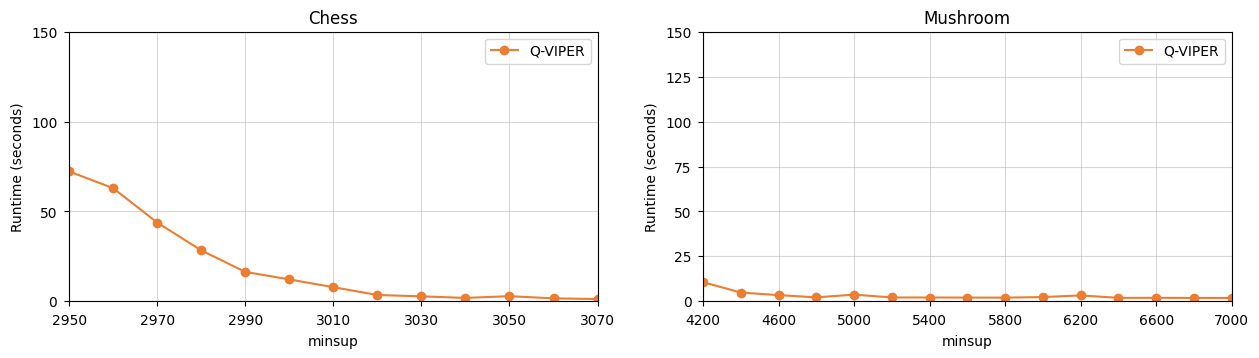

In [ ]:
plt.figure(figsize=(15, 3.5))

# chess dataset plot
plt.subplot(1, 2, 1)
plt.plot(chess_minsup, chess_runtime, marker='o', color='#ec7e32')
plt.yticks([0, 50, 100, 150])
plt.xticks([i for i in range(2950, 3071, 20)])
plt.xlabel('minsup', labelpad=5)
plt.ylabel('Runtime (seconds)', labelpad=5)
plt.tick_params(axis='both', which='both', pad=5)
plt.ylim(0, 150)
plt.xlim(left=chess_minsup[0], right=chess_minsup[-1])
plt.grid(True, alpha=0.5)
plt.legend(['Q-VIPER'])
plt.title('Chess')

# mushroom dataset plot
plt.subplot(1, 2, 2)
plt.plot(mushroom_minsup, mushroom_runtime, marker='o', color='#ec7e32')
plt.yticks([i for i in range(0, 151, 25)])
plt.xticks([i for i in range(4200, 7001, 400)])
plt.xlabel('minsup', labelpad=5)
plt.ylabel('Runtime (seconds)', labelpad=5)
plt.tick_params(axis='both', which='both', pad=5)
plt.ylim(0, 150)
plt.xlim(left=mushroom_minsup[0], right=mushroom_minsup[-1])
plt.grid(True, alpha=0.5)
plt.legend(['Q-VIPER'])
plt.title('Mushroom')

plt.show()

In [ ]:
print('Chess Dataset')
print('--------------------')
for minsup, frequent_itemexpsets in chess_frequent.items():
    print(f'Frequent itemexpsets with minsup={minsup}:')
    for i, exp in enumerate(frequent_itemexpsets):
        print(f'There are {len(exp)} frequent itemexpsets with k={i+1}.')

    print('\n')

Chess Dataset
--------------------
Frequent itemexpsets with minsup=2950:
There are 39 frequent itemexpsets with k=1.
There are 468 frequent itemexpsets with k=2.
There are 2538 frequent itemexpsets with k=3.
There are 6723 frequent itemexpsets with k=4.
There are 7776 frequent itemexpsets with k=5.
There are 3645 frequent itemexpsets with k=6.
There are 0 frequent itemexpsets with k=7.


Frequent itemexpsets with minsup=2960:
There are 39 frequent itemexpsets with k=1.
There are 459 frequent itemexpsets with k=2.
There are 2403 frequent itemexpsets with k=3.
There are 6156 frequent itemexpsets with k=4.
There are 7533 frequent itemexpsets with k=5.
There are 2916 frequent itemexpsets with k=6.
There are 0 frequent itemexpsets with k=7.


Frequent itemexpsets with minsup=2970:
There are 39 frequent itemexpsets with k=1.
There are 432 frequent itemexpsets with k=2.
There are 2187 frequent itemexpsets with k=3.
There are 5265 frequent itemexpsets with k=4.
There are 5832 frequent itemexp

In [ ]:
print('Mushroom Dataset')
print('--------------------')
for minsup, frequent_itemexpsets in mushroom_frequent.items():
    print(f'Frequent itemexpsets with minsup={minsup}:')
    for i, exp in enumerate(frequent_itemexpsets):
        print(f'There are {len(exp)} frequent itemexpsets with k={i+1}.')

    print('\n')

Mushroom Dataset
--------------------
Frequent itemexpsets with minsup=4200:
There are 39 frequent itemexpsets with k=1.
There are 351 frequent itemexpsets with k=2.
There are 1431 frequent itemexpsets with k=3.
There are 2754 frequent itemexpsets with k=4.
There are 1944 frequent itemexpsets with k=5.
There are 0 frequent itemexpsets with k=6.


Frequent itemexpsets with minsup=4400:
There are 33 frequent itemexpsets with k=1.
There are 315 frequent itemexpsets with k=2.
There are 1107 frequent itemexpsets with k=3.
There are 1620 frequent itemexpsets with k=4.
There are 972 frequent itemexpsets with k=5.
There are 0 frequent itemexpsets with k=6.


Frequent itemexpsets with minsup=4600:
There are 30 frequent itemexpsets with k=1.
There are 234 frequent itemexpsets with k=2.
There are 783 frequent itemexpsets with k=3.
There are 1215 frequent itemexpsets with k=4.
There are 729 frequent itemexpsets with k=5.
There are 0 frequent itemexpsets with k=6.


Frequent itemexpsets with minsup